# 1. 필요 라이브러리 불러오기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 2. 데이터 불러오기

In [3]:
data_dir = os.getenv('HOME')+'/Desktop/aiffel_data/EXP4/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 3. EDA


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
# 결측치 확인
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [5]:
# date 컬럼 분리
for a in train, test:
    a['year'] = a['date'].apply(lambda x : x[0:4],range(len(a)))
    a['month'] = a['date'].apply(lambda x : x[4:6])
    a['day'] = a['date'].apply(lambda x : x[6:8])

In [6]:
sub_id = test['id']

In [7]:
# 필요없는 date 칼럼 삭제
del train['date']
del test['date']
del train['id']
del test['id']

In [8]:
# 데이터 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15035 non-null  float64
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

- Date 컬럼에서 분할된 year / month / day를 제외하고는 모두 숫자형으로 이루어져 있다

In [9]:
print('총 데이터 개수:', train.shape[0]*train.shape[1])
print('train 결측치 개수:', sum(train.isnull().sum()))
print('test 결측치 개수:', sum(test.isnull().sum()))

총 데이터 개수: 330770
train 결측치 개수: 0
test 결측치 개수: 0


## 3-1 종속 변수(price) 탐색

In [10]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

- price값의 분포를 확인해 보니 좌측으로 치우쳐져 있음을 확인할 수 있다. 따라서 로그를 통한 정규화가 필요하다고 생각한다.

<AxesSubplot:xlabel='price', ylabel='Density'>

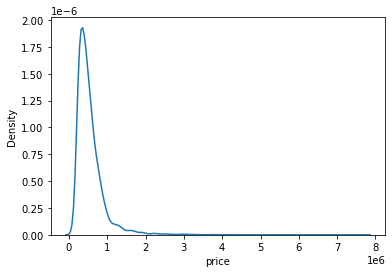

In [11]:
# 히스토그램을 통한 분포 확인
sns.kdeplot(train['price'])

## 3-2 설명변수 탐색

- price와 각 컬럼의 상관관계를 비교하기에 앞서 수치형 자료와 범주형 자료 분리를 통해  
  수치형 자료는 피어슨 상관계수를 범주형 자료는 스피어만 상관계수를 사용해 상관계수를 파악해보고자 한다.

- 범주형 자료에는 grade / condition / warterfront / view가 있다.

- 범주형 자료 분리 및 그래프 그리기

In [12]:
train_sp = pd.DataFrame()
for i in ['price','grade','condition','waterfront','view']:
    train_sp[i] = train[i]
train_sp

,price,grade,condition,waterfront,view
0,221900.0,7,3,0,0
1,180000.0,6,3,0,0
2,510000.0,8,3,0,0
3,257500.0,7,3,0,0
4,291850.0,7,3,0,0
...,...,...,...,...,...
15030,610685.0,9,3,0,0
15031,1007500.0,9,3,0,0
15032,360000.0,8,3,0,0
15033,400000.0,8,3,0,0


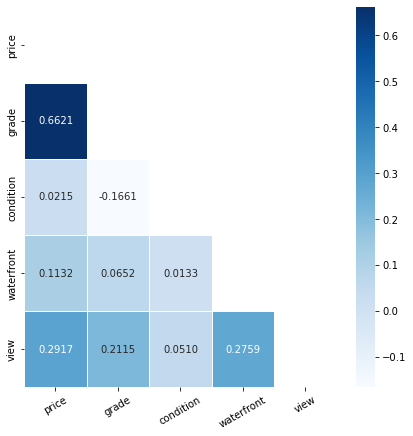

In [13]:
# 상관계수 확인
plt.figure(figsize=(7,7))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train_sp.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # 위쪽 삼각형 True 아래쪽 삼각형 False

sns.heatmap(data = train_sp.corr(method='spearman'), annot=True,  # annot : 실제값 그리기 
mask = mask , fmt = '.4f', linewidths=.5, cmap='Blues') # mask = 표시하지 않을 부분 지정
plt.xticks(rotation = 30)
plt.show()


범주형 자료의 스피어만 상관계수를 비교해 보니 grade > view > waterfront > condition 순서이다

- 수치형 자료 분리 및 그래프 그리기

In [14]:
# 수치형 데이터 분리 + year,month,day 컬럼
train_p = train.drop(['grade','condition','waterfront','view','year','month','day'],axis=1)
train_p



,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,180000.0,2,1.00,770,10000,1.0,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,510000.0,3,2.00,1680,8080,1.0,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,257500.0,3,2.25,1715,6819,2.0,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,291850.0,3,1.50,1060,9711,1.0,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,610685.0,4,2.50,2520,6023,2.0,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,1007500.0,4,3.50,3510,7200,2.0,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,360000.0,3,2.50,1530,1131,3.0,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,400000.0,4,2.50,2310,5813,2.0,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


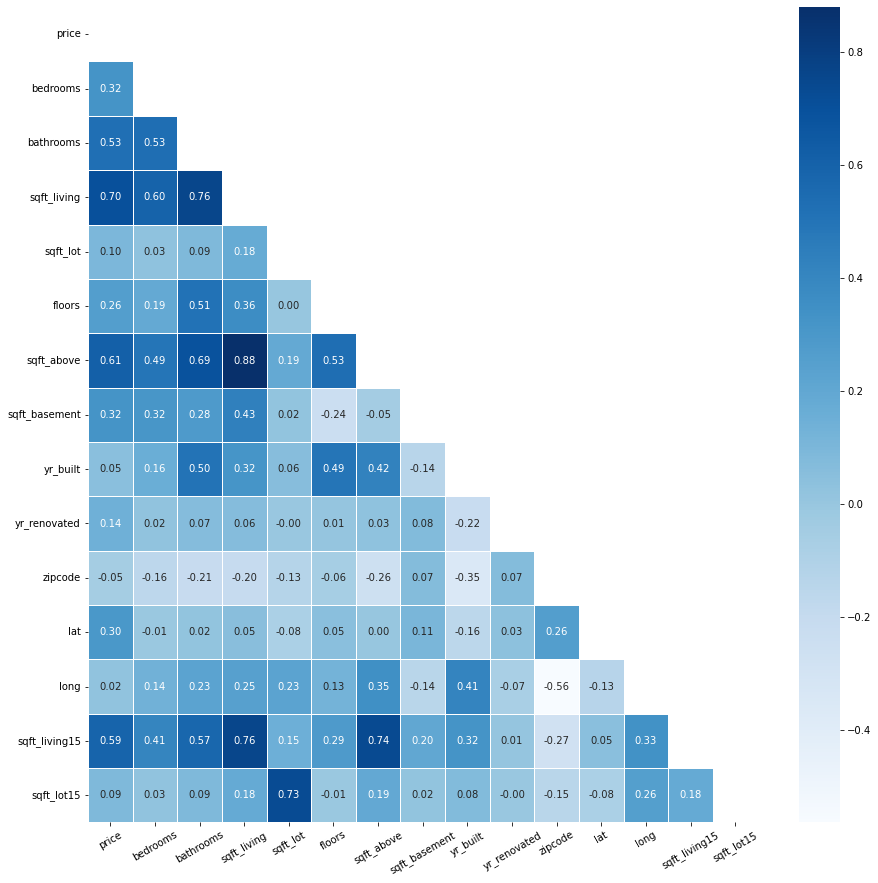

In [15]:
# 상관계수 확인
plt.figure(figsize=(15,15))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train_p.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # 위쪽 삼각형 True 아래쪽 삼각형 False

sns.heatmap(data = train_p.corr(), annot=True,  # annot : 실제값 그리기 
mask = mask , fmt = '.2f', linewidths=.5, cmap='Blues') # mask = 표시하지 않을 부분 지정
plt.xticks(rotation = 30)
plt.show()


각 컬럼별 상관관계 비교  
price와 높은 상관관계를 보이는 컬럼은 sqft_living / sqft_above / sqft_living15 순서이다.  
낮은 상관관계(0.0x)를 보이는 컬럼은 long / zipcode / yt_built / condition 이다.

<AxesSubplot:xlabel='long', ylabel='lat'>

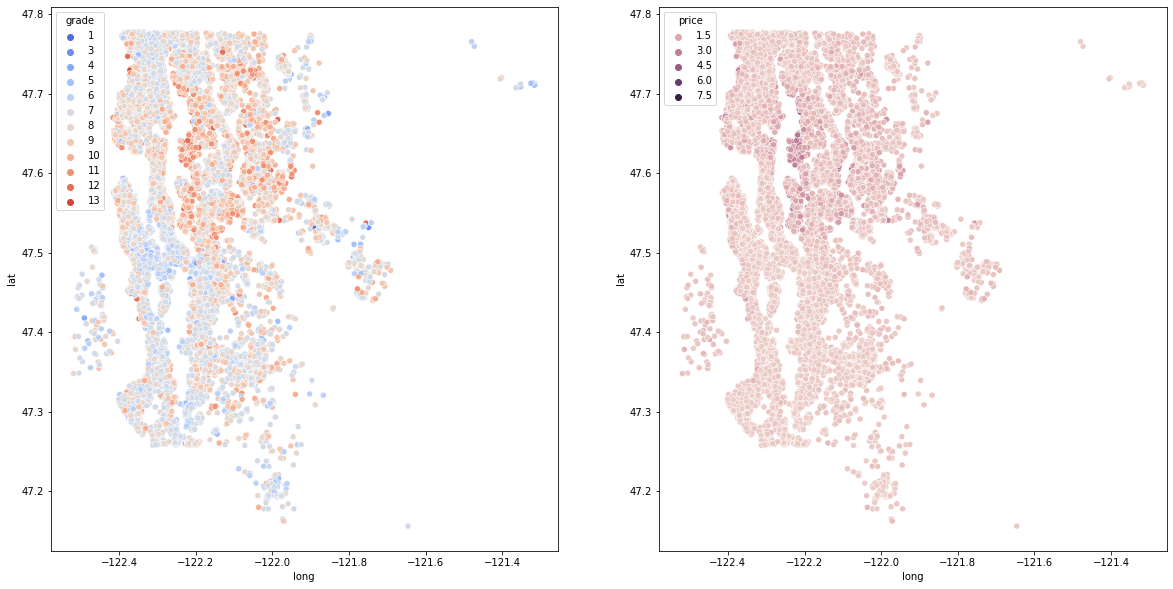

In [16]:
f , ax = plt.subplots(1,2, figsize = (20,10))
palette1 = sns.color_palette('coolwarm',12)
sns.scatterplot(x = train['long'], y = train['lat'], hue = train['grade'],  palette = palette1, ax=ax[0])
sns.scatterplot(x = train['long'], y = train['lat'], hue = train['price'], ax= ax[1])

위도와 경도를 통해 지도를 그리고 grade와 price에 따라서 색상 표현을 다르게 그려본 결과  
높은 grade를 가지고 있는 집들은 지도상 가운데에 위치해 있었으며, 동일하게 높은 price를 가지고 있는 집들도 가운데에 위치해 있었다.   
당연하게도 높은 grade를 가진 집은 높은 price를 가지고 있음을 확인 할 수 있었다.

# 4. 이상치 탐색

높은 상관계수를 보이는 grade / sqft_living / sqft_above / sqft_living15의 이상치를 확인한다.

#### grade(집의 등급)

grade가 높을 수록(집의 등급이 높을 수록) 집의 가격이 높을 것이다.  
따라서 해당 grade에서 높은 가격을 보이는 것들은 다음 graded의 값에 들어갔어야 할 점들이라 생각해 이상치라고 판별할 것이다.  
예시) 6의 boxplot에서 maxmum을 넘어서는 이상치 중 다음 단계인 7의 maxmum을 넘어서는 값들을 이상치로 판별하겠다.(7의 maxmum값에서 좌측으로 임의의 직선 선을 그었을 때, 임의의 선 이상의 값들을 삭제하겠다.)

maxmum을 넘어서는 이상치를 많이 가지고 있는 5등급 부터 11등급 까지만 삭제 해보겠다.

<AxesSubplot:xlabel='grade', ylabel='price'>

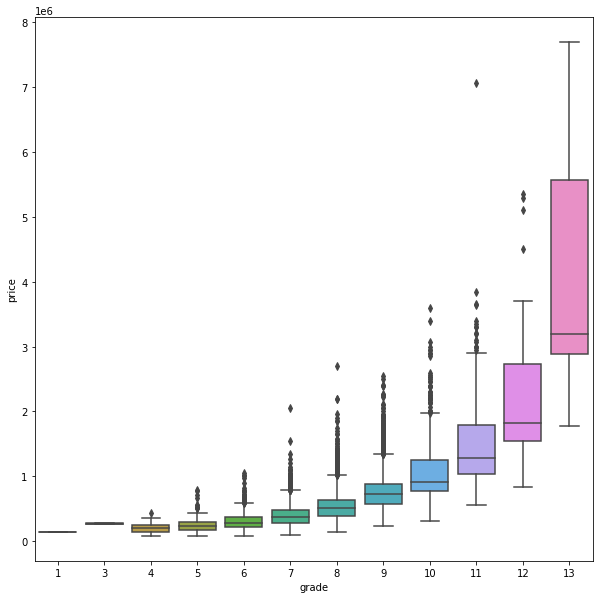

In [17]:
plt.figure(figsize=(10,10))
sns.boxplot(train['grade'], train['price'])

In [18]:
# 전체 grade 중 각 숫자에 맞는 grade만 추출
grade_5= train[train['grade'] == 5]
grade_6= train[train['grade'] == 6]
grade_7= train[train['grade'] == 7]
grade_8= train[train['grade'] == 8]
grade_9= train[train['grade'] == 9]
grade_10= train[train['grade'] == 10]
grade_11= train[train['grade'] == 11]
grade_12= train[train['grade'] == 12]

In [19]:
# 리스트 작성
grade_index = [grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12]

# 빈 리스트 생성
grade_list = []

for i in range(8):
    if i == 7:
        break
    q1 = np.percentile(grade_index[i+1]['price'].values,25)
    q3 = np.percentile(grade_index[i+1]['price'].values,75)

    iqr  = q3 - q1
    minlier = q1 - (iqr * 1.5)
    maxlier = q3 + (iqr * 1.5)

    outlier_idx = grade_index[i]['price'][(grade_index[i]['price'] >maxlier)].index # 해당 인덱스만 추출 
    grade_list.append(outlier_idx)


In [20]:
# 삭제 전 데이터 크기 확인
print(train.shape)

# 이상치 제거
for i in range(7):
    train.drop(grade_list[i],axis=0,inplace=True)

(15035, 22)


In [21]:
# 삭제 후 데이터 크기 확인
train.shape

(14958, 22)

이전 15035개의 row에서 75개의 이상치를 삭제한 후 14958개의 row만 남은 것을 확인

<AxesSubplot:xlabel='grade', ylabel='price'>

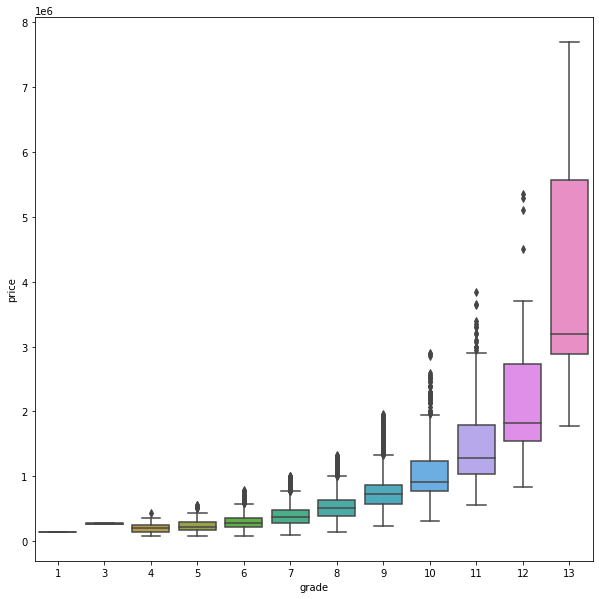

In [22]:
# 그래프를 그려서 이상치 제거가 잘 되었는지 확인
plt.figure(figsize=(10,10))
sns.boxplot(train['grade'], train['price'])

#### sqft_living (주거 공간의 평방 피트)
- 주거 공간의 넓이 또한 넓을 수록 가격이 높은 모습을 보이고 있다.  
- 실제로 넓은 집을 가졌을 수 있지만, 데이터 학습에 악영향을 줄 수 있어 10,000을 넘어서는 값은 제거하는 것이 바람직 하다고 생각이 된다.

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

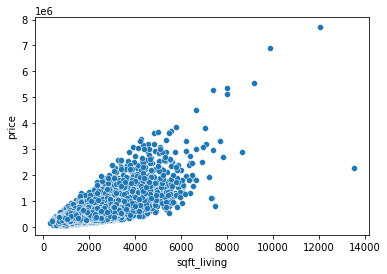

In [23]:
sns.scatterplot(train['sqft_living'], train['price'])

In [24]:
# 이상치 값 추출
sqfr_living_out = train.loc[train['sqft_living'] > 10000]
print(sqfr_living_out)

# 삭제 전 데이터 크기 확인
train.shape

          price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
5108  7700000.0         6        8.0        12050     27600     2.5   
8912  2280000.0         7        8.0        13540    307752     3.0   

      waterfront  view  condition  grade  ...  yr_built  yr_renovated  \
5108           0     3          4     13  ...      1910          1987   
8912           0     4          3     12  ...      1999             0   

      zipcode      lat     long  sqft_living15  sqft_lot15  year  month day  
5108    98102  47.6298 -122.323           3940        8800  2014     10  13  
8912    98053  47.6675 -121.986           4850      217800  2014     05  05  

[2 rows x 22 columns]


(14958, 22)

In [25]:
# 이상치 제거
train.drop(sqfr_living_out.index,axis=0,inplace=True)
# 삭제 후 데이터 크기 확인
train.shape

(14956, 22)

#### sqft_above (지하실을 제외한 평방 피트)
- sqft_living과 같이 실제로 넓은 집을 가졌을 수도 있지만 모델의 학습을 위해 7,000을 넘는 값은 삭제한다.

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

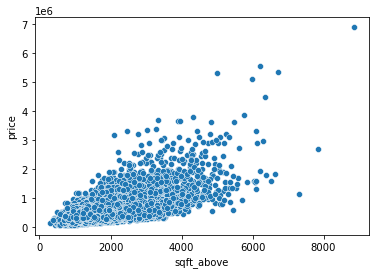

In [26]:
sns.scatterplot(train['sqft_above'], train['price'])

In [27]:
# 이상치 값 추출
sqfr_above_out = train.loc[train['sqft_above'] > 7000]
print(sqfr_above_out)

# 삭제 전 데이터 크기 확인
train.shape

           price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
6469   6885000.0         6       7.75         9890     31374     2.0   
12921  1135250.0         5       4.00         7320    217800     2.0   
13809  2700000.0         4       4.00         7850     89651     2.0   

       waterfront  view  condition  grade  ...  yr_built  yr_renovated  \
6469            0     4          3     13  ...      2001             0   
12921           0     0          3     11  ...      1992             0   
13809           0     0          3     12  ...      2006             0   

       zipcode      lat     long  sqft_living15  sqft_lot15  year  month day  
6469     98039  47.6305 -122.240           4540       42730  2014     09  19  
12921    98058  47.4473 -122.086           3270       34500  2014     07  08  
13809    98027  47.5406 -121.982           6210       95832  2015     01  22  

[3 rows x 22 columns]


(14956, 22)

In [28]:
# 이상치 제거
train.drop(sqfr_above_out.index,axis=0,inplace=True)
# 삭제 후 데이터 크기 확인
train.shape

(14953, 22)

#### bedrooms (방 개수)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

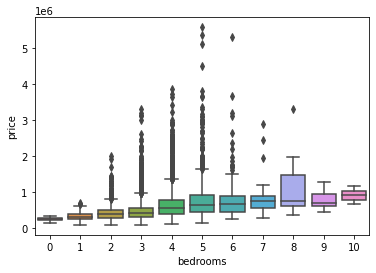

In [29]:
sns.boxplot(x = train['bedrooms'],y= train['price'])

그래프를 보면 방의 수가 9까지는 점진적인 증가를 보이지만  
10 부터는 증가하는 추세가 아닌듯으로 판단이 된다.   
따라서 10 이상의 값들은 제거하는 편이 모델링에 도움이 된다고 생각한다.

In [30]:
# 이상치 값 추출
bedrooms_out = train.loc[train['bedrooms'] >= 10]
print(bedrooms_out)

# 삭제 전 데이터 크기 확인
train.shape

           price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
9280   1148000.0        10       5.25         4590     10920     1.0   
10575   650000.0        10       2.00         3610     11914     2.0   

       waterfront  view  condition  grade  ...  yr_built  yr_renovated  \
9280            0     2          3      9  ...      2008             0   
10575           0     0          4      7  ...      1958             0   

       zipcode      lat     long  sqft_living15  sqft_lot15  year  month day  
9280     98004  47.5861 -122.113           2730       10400  2014     08  14  
10575    98006  47.5705 -122.175           2040       11914  2014     10  29  

[2 rows x 22 columns]


(14953, 22)

In [31]:
# 이상치 제거
train.drop(bedrooms_out.index,axis=0,inplace=True)
# 삭제 후 데이터 크기 확인
train.shape

(14951, 22)

# 4-1 변수 제거
- 상단에서 상관계수를 비교해 보았다. 약한 상관계수를 보이는 컬럼을 원활한 모델링을 위해서 삭제하고자 한다.
- 삭제하려는 컬럼은 zipcode와 yr_built이다.

In [32]:
# 삭제 전 데이터 크기 확인
train.shape

# 컬럼 삭제
train.drop(['zipcode','yr_built','year','month','day'],axis=1,inplace=True)
test.drop(['zipcode','yr_built','year','month','day'],axis=1,inplace=True)
# 삭제 후 데이터 크기 확인 
train.shape

(14951, 17)

# 5. 정규화

In [33]:
train.shape
train.head()
train = train.astype(float)

In [34]:
test = test.astype(float)

- 변수와의 분포를 확인하고 정규화가 필요한 컬럼은 정규화를 진행한다.

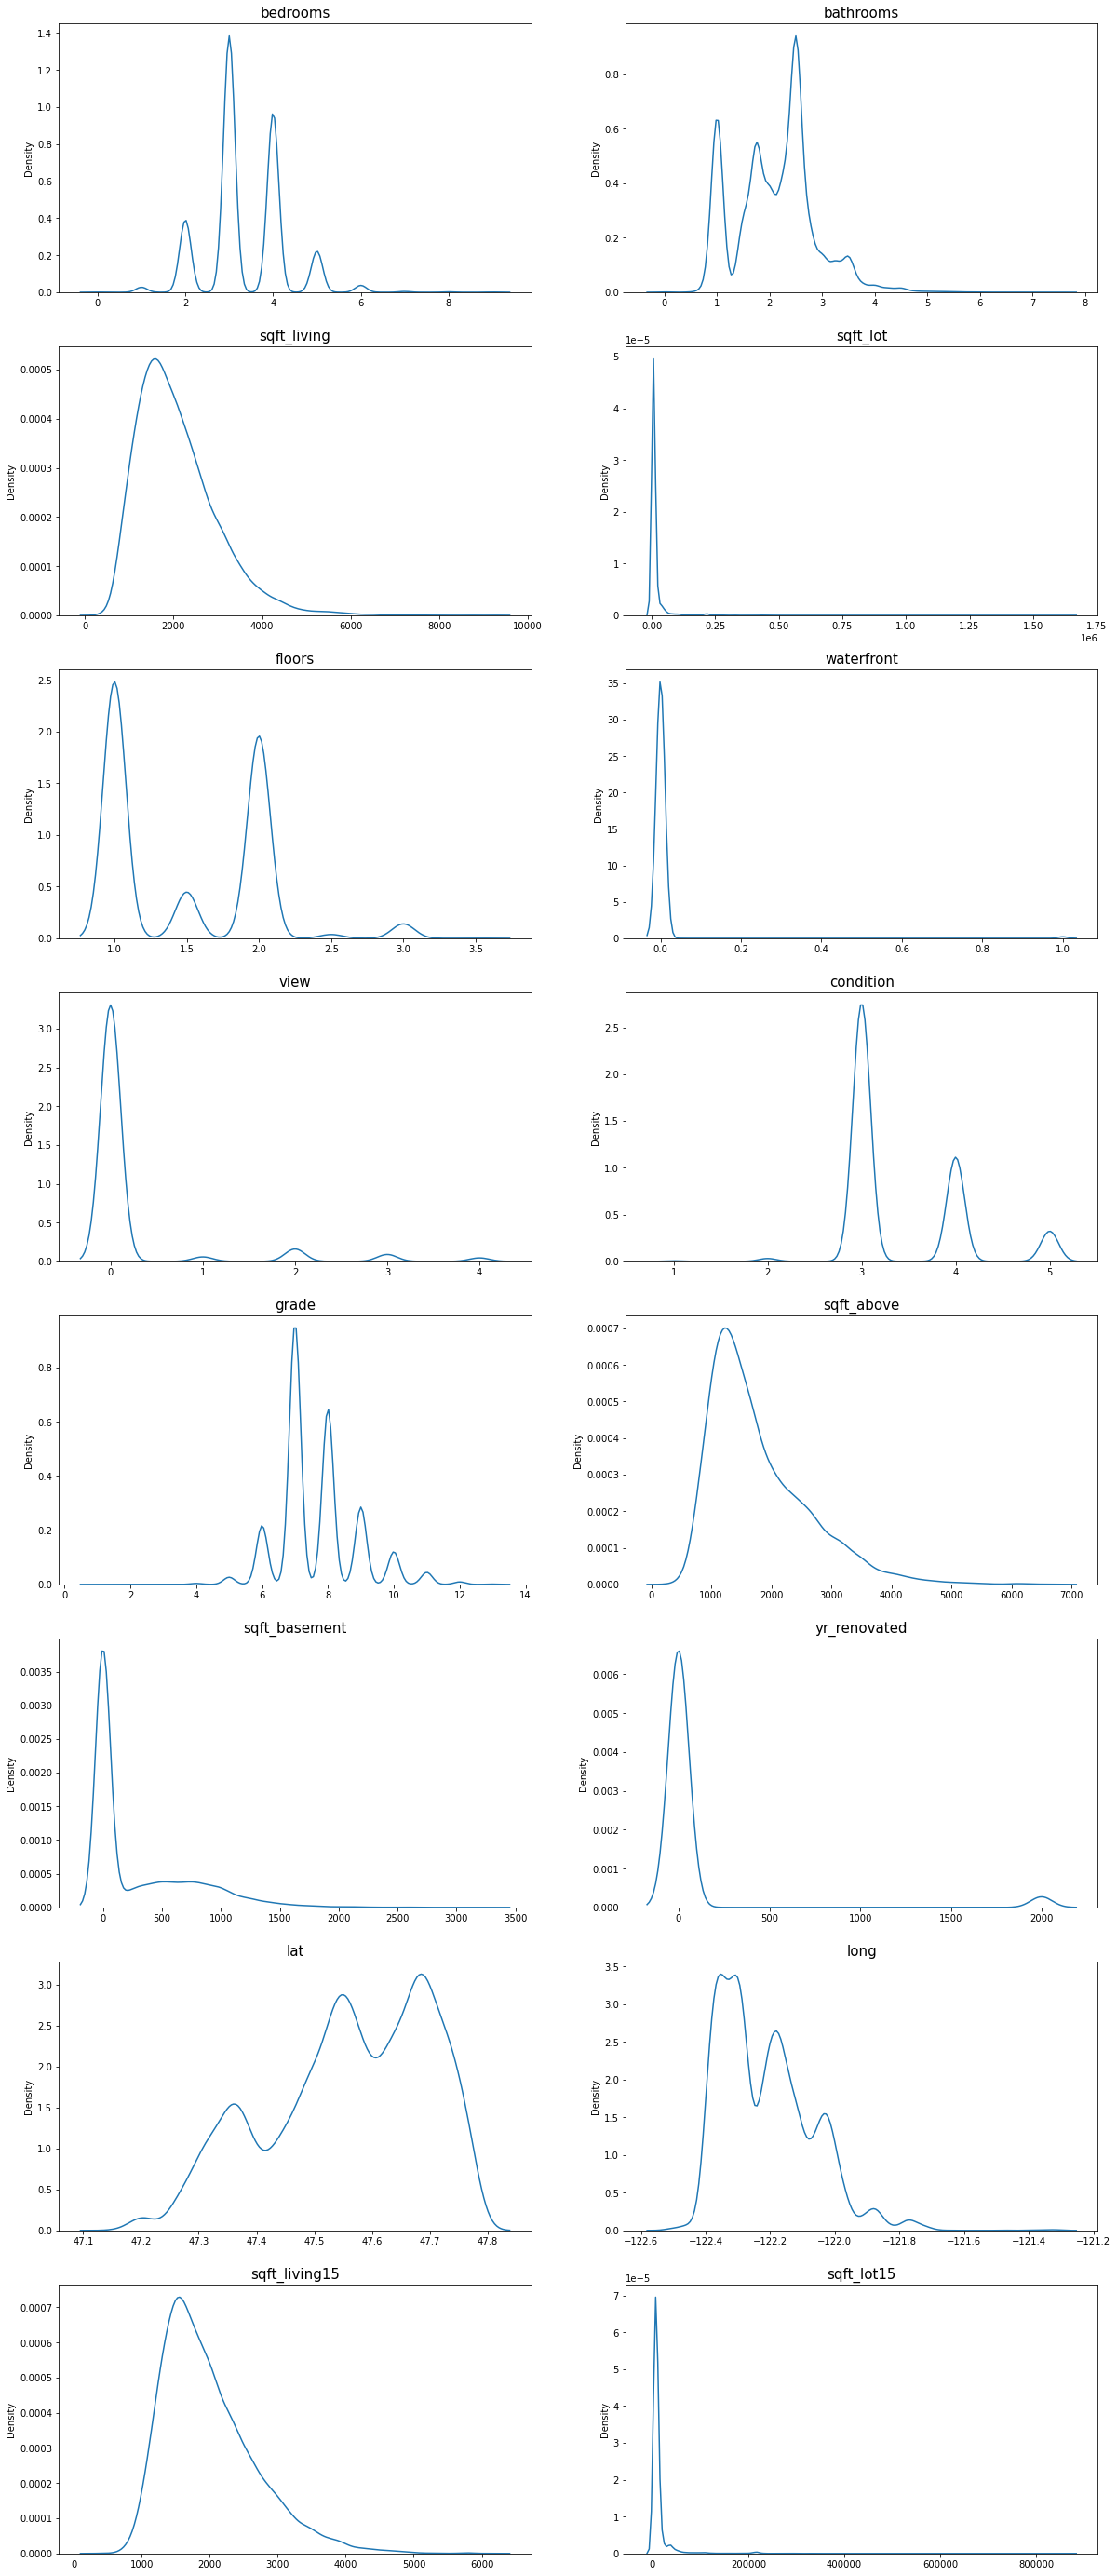

In [35]:
fig, ax = plt.subplots(8, 2, figsize=(20, 50))  

# price 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
# 총 컬럼 수는 22개 이지만, price, year, month, day 컬럼을 제외한 18개의 컬럼의 분포를 확인
count = 1
columns = train.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col]) # 그래프 데이터 및 위치 지정
        ax[row][col].set_title(columns[count], fontsize=15) # 타이틀 제목 설정
        ax[row][col].set_xlabel("") # 제목과 x축 라벨이 겹쳐서 x축 라벨 삭제
        count += 1
        if count == 17 :
            break

그래프를 보았을 때, 좌 혹은 우측으로 치우쳐지는 경향을 확인 할 수 있었다.   
price / sqft_living / sqft_lot / sqft_above / sqft_basement / yr_renoveted / sqft_lot15 / sqft_living15의 그래프들은 정규화가 필요해 보인다

해당 값들 중 0을 가지고 있다는 것은  
sqfr_basement: 지하실의 평방 피트 가 0이다. = 지하실이 없다.  
yr_renovated: 재건축이 된 년도가 0이다. = 재건축이 된 적이 없다.  
waterfront: 리버뷰가 0이다 = 리버뷰가 아니다


- 로그 정규화가 필요한 컬럼을 정규화하고 그래프를 통해 잘 정규화 되었는지 확인한다.


In [36]:
log_columns = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','yr_renovated','sqft_lot15','sqft_living15']

for c in log_columns:
    train[c] = np.log1p(train[c].values)

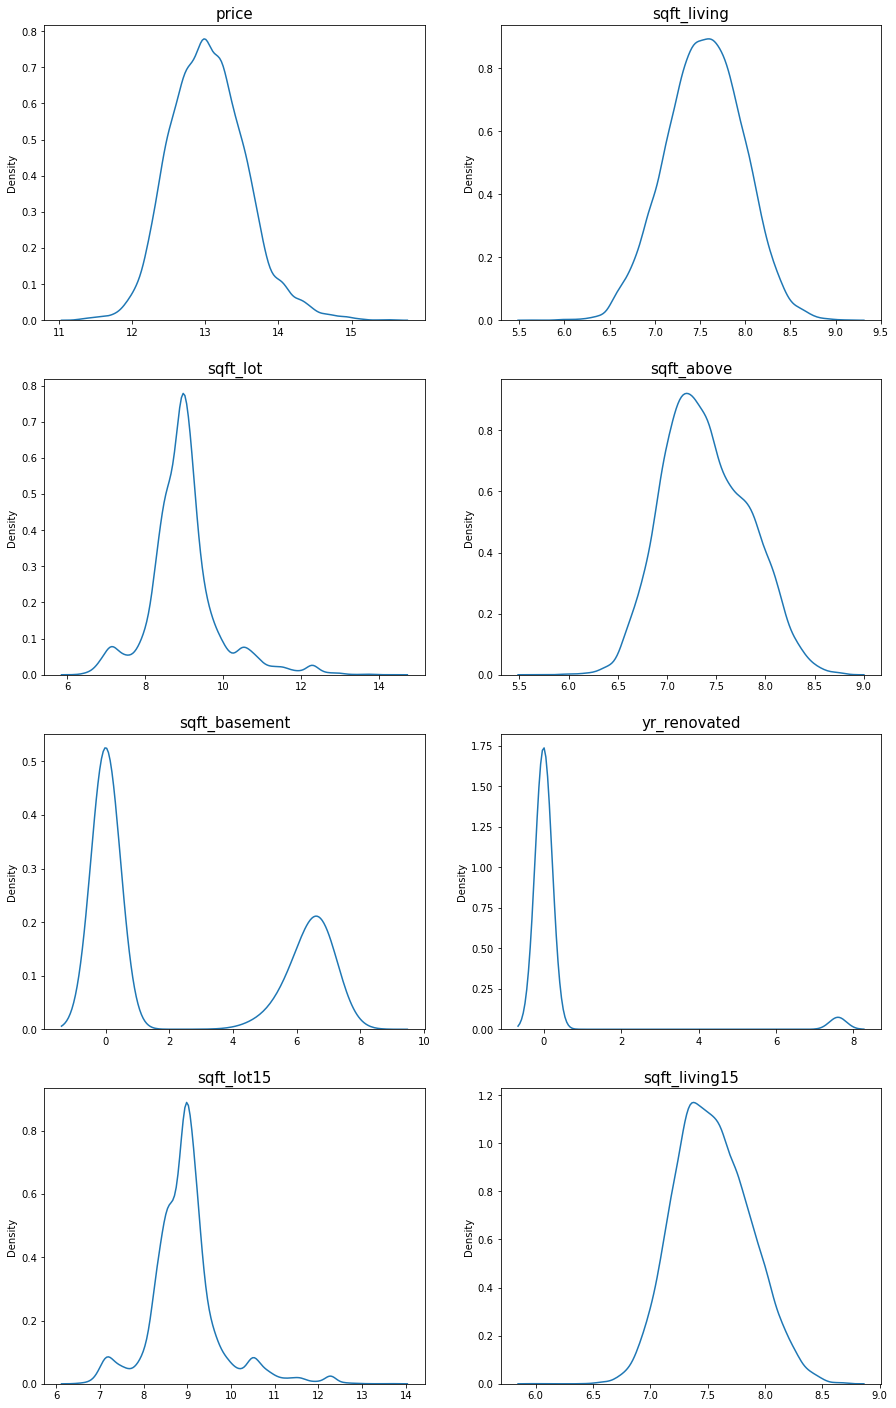

In [37]:
fig, ax = plt.subplots(4, 2, figsize=(15, 25))  

count = 0
for row in range(4):
    for col in range(2):
        if count == 8 :
            break
        sns.kdeplot(data=train[log_columns[count]], ax=ax[row][col]) # 그래프 데이터 및 위치 지정
        ax[row][col].set_title(log_columns[count], fontsize=15) # 타이틀 제목 설정
        ax[row][col].set_xlabel("") # 제목과 x축 라벨이 겹쳐서 x축 라벨 삭제   
        count += 1

In [38]:
target = train['price']
del train['price']
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


# 6. 모델링

##### xgboost
- 부스팅 기법을 이용하여 구현한 알고리즘인 Gradient boost에 병렬 학습이 되도록 구현한 라이브러리
- 회귀와 분류 모두 지원 

##### Light GBM
- 리프 중심의 트리 분할 방식으로 트리를 수직으로 생성할 때, 트리의 균형을 맞추지 않고   
  최대 손실 값을 가지는 리프 노트를 지속적으로 분할 하면서 트리의 깊이가 깊어지고 비대칭적인 트리가 생성된다.   
  하지만 최대 손실값을 가지는 리프 노드를 반복할수록 결국은 균형 트리의 분할 방식보다 예측 오류 손실을 최소화 할 수 있다.
##### ------------------------------------------------------------------
- 부스팅: 여러가지 약한 의사결정 트리를 토대로 조합하는 앙상블 기법
- 약한 예측 모형들에 학습 에러에 가중치를 두어 강한 예측 모형을 만드는 기법
- 사이킷런 성능평가 지표(https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [39]:
# 필요 라이브러리 가져오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 4가지 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [40]:

random_state = 415
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 8. 그리드 서치 

- 장점: 원하는 범위를 정확하게 비교 분석 가능 
- 단점: 시간이 오래걸림

- 그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리  
  - 그리드 탐색은 사람이 정해둔 값으로 조합을 탐색함으로 최적의 조합을 놓칠 가능성이 존재 

- 그리드 서치에 대한 모델을 평가하는 지표는 R2(결정계수)를 사용한다.


#### LGBM
##### num_leaves / max_depth / min_child_samples / sub_sample 파라미터가 Light GBM 파라미터 튜닝에 있어서 가장 중요한 파라미터들이다
- learning_rate[default=0.1] : 학습 단계별로 이전 결과를 얼마나 반영할지 설정한다.    
  일반적으로는 0.01 ~ 0.2 사이의 값을 쓰며 너무 작게 하면 시간이 더 오래 걸리게 된다
- max_depth[default=6] : 트리의 최대 깊이를 뜻하며 일반적으로 3~10의 값으로 한다.  
- num_leaves : 2^(max_depth)으로 해당 값보다 작아야 더 좋은 성능을 얻을 수 있음     
  ex) 2^(max_depth) = 127 보다 적은 70~80사이
- n_estimators[default=100] : 트리 모델의 개수  
- min_data_in_leaf : Leaf가 가지고 있는 최소한의 레코드 수입니다. 디폴트값은 20으로 최적 값. 과적합을 해결할 때 사용되는 파라미터이다.
- min_child_samples 파라미터는 최종 결정 클래스인 Leaf Node가 되기 위해서 최소한으로 필요한 데이터 개체의 수를 의미하며, 과적합을 제어하는 파라미터이다.  
  최적값은 훈련 데이터의 개수와 num_leaves에 의해 결정 
- min_child_weight[default=1] : child 에서 필요한 모든 관측치에 대한 가중치의 최소합    
  이 값보다 샘플 수가 작으면 leaf node가 된다. 너무 크게 설정하면 Under-fitting 될 수 있다. 
- subsample[default=1] : 각 트리마다 데이터 샘플링 비율 over-fitting방지  
  일반적으로 0.5 ~ 1을 사용
- reg_lambda [default=1] : L2 규제(Ridge)  
- reg_alpha [default=0] : L1 규제(Lasso)  
  
- early_stopping_rounds : 최대한 몇 개의 트리를 완성할 것인지 valid loss에 더이상 진전이 없다면 멈춘다.     
  n_estimators가 높을 때 주로 사용하며 과적합을 방지


참고 블로그: https://velog.io/@highway92/XGBoost-파라미터들 / https://greeksharifa.github.io/machine_learning/2019/12/09/Light-GBM/  

#### XGB
- eta(기본값 0.3) = 일반적으로 확습률(learning rate)로 불리우는 파라미터 weak learner의 반영 수준을 나타냄  
  범위는 0 ~ 1로 클 수록 모형의 업데이트 속도는 빨라짐. 
  클수록 과적합의 이슈 발생 가능성이 높음
- num_boost_around(기본값 10) = 학습에 활용될 weak learner의 반복 수
- min_child_weight(기본값 1) = leaf node에 포함되는 최소 관측치의 수를 의미  
  작은 값을 가질수록 과적합 발생 가능성이 높음(과적합 조절 용도로 사용됨) / 범위: 0 ~ ∞
- gamma(기본값 0) = leaf node의 추가분할을 결정할 최소손실 감소값   
  해당값보다 손실이 크게 감소할 때 분리 / 값이 클수록 과적합 감소효과 / 범위: 0 ~ ∞
- max_depth(기본값 6) =	트리의 최대 깊이를 설정  
  0을 지정하면 깊이의 제한이 없음 / 과적합에 가장 민감하게 작용하는 파라미터 중 하나임 / 범위: 0 ~ ∞
- sub_sample(기본값 1) = 학습 시 데이터 샘플링 비율을 지정(과적합 제어)   
  일반적으로 0.5 ~ 1 사이의 값을 사용 / 범위: 0 ~ 1
- colsample_bytree(기본값 1) = 트리 생성에 필요한 feature의 샘플링에 사용  
  feature가 많을 때 과적합 조절에 사용 / 범위: 0 ~ 1
- lambda(기본값 1) = L2 Regularization 적용 값   
  feature 개수가 많을 때 적용 검토 / 클수록 과적합 감소 효과
- alpha(기본값 0) = L1 Regularization 적용 값   
  feature 개수가 많을 때 적용 검토 / 클수록 과적합 감소 효과
  
- scale_pos_weight(기본값 1) = 불균형 데이터셋의 균형을 유지
   
참고 블로그 : https://zzinnam.tistory.com/entry/XGboost-주요-하이퍼파라미터-with-파이썬#recentComments

#### RandomForest

- n_estimators[default=100] = 트리 모델의 개수
  늘리면 성능은 좋아지나 시간 오래걸림
- min_samples_split[default=2] = 노드를 분할하기 위한 최소한의 샘플 데이터 수
  과적합 방지용이며 작을수록 과적합 가능성 증가
- min_samples_leaf = 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수
  min_samples_split과 함께 과적합 제어 용도
- max_features[default=auto] = 최적의 분할을 위해 고려할 최대 feature 개수
- max_depth[default=None] = 트리의 최대 깊이
  깊이가 깊어지면 과적합 가능성 증가
  
- max_leaf_nodes = 리프노드의 최대 개수

참고 블로그: https://injo.tistory.com/30

In [96]:
# 최적의 RMSE값을 찾기 위한 하이퍼파리미터 실험
from sklearn.model_selection import GridSearchCV # 라이브러리 불러오기

# 탐색할 하이퍼 파리미터 설정 param_grid는 딕셔너리 형태로 설정
param_grid_LGBM = {'learning_rate':[0.01,0.1,0.2],'num_leaves':[70,80],'max_depth':[7,8,9],
                   'min_child_samples':[50,60],'subsample':[0.5,0.8,1]}
param_grid_XGB = {'learning_rate':[0.01,0.1,0.2],'max_depth':[7,8,9],
                   'subsample':[0.5,0.8,1],'eta':[0.3,0.4,0.5]}
param_grid_RF = {'max_depth':[1,3,5,7],'n_estimators':[100,200,300],'min_samples_split':[2,7,10]}



# 모델 준비
model_LGBM = LGBMRegressor(random_state=random_state)
model_XGB = XGBRegressor(random_state=random_state)
model_RF = RandomForestRegressor(random_state=random_state)

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [97]:
grid_model_LGMB = GridSearchCV(model_LGBM, param_grid=param_grid_LGBM, \
                        scoring='r2', \
                        cv=5, verbose=1, n_jobs=5)

grid_model_LGMB.fit(train, target)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=415), n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [7, 8, 9], 'min_child_samples': [50, 60],
                         'num_leaves': [70, 80], 'subsample': [0.5, 0.8, 1]},
             scoring='r2', verbose=1)

In [98]:
grid_model_XGM = GridSearchCV(model_XGB, param_grid=param_grid_XGB, \
                        scoring='r2', \
                        cv=5, verbose=1, n_jobs=5)

grid_model_XGM.fit(train, target)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [99]:
grid_model_RF = GridSearchCV(model_RF, param_grid=param_grid_RF, \
                        scoring='r2', \
                        cv=5, verbose=1, n_jobs=5)

grid_model_RF.fit(train, target)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=415), n_jobs=5,
             param_grid={'max_depth': [1, 3, 5, 7],
                         'min_samples_split': [2, 7, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

결정계 수란 = '회귀 모델의 성과 지표'  
1에 가까울 수록 좋은 회귀 모델  
0에 가까울 수록 나쁜 모델  
음수가 나올경우, 바로 폐기해야 하는 모델
SSR > SST 보다 클 경우 음수가 나올수가 있음
이는 모델의 예측값이 평균값으로 예측하는것보다 정확하지 않을때 발생함

In [100]:
print('Grid Rearch 결과')
print('='*100)
print('LGBM모델의 최적 파라미터:',grid_model_LGMB.best_params_)
print('LGBM모델의 결정계수: {0:.5f}'.format(grid_model_LGMB.best_score_))
print('='*100)
print('XGB모델의 최적 파라미터:',grid_model_XGM.best_params_)
print('XGB모델의 결정계수: {0:.5f}'.format(grid_model_XGM.best_score_))
print('='*100)
print('RF모델의 최적 파라미터:',grid_model_RF.best_params_)
print('RF모델의 결정계수: {0:.5f}'.format(grid_model_RF.best_score_))
print('='*100)

Grid Rearch 결과
LGBM모델의 최적 파라미터: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_samples': 50, 'num_leaves': 80, 'subsample': 0.5}
LGBM모델의 결정계수: 0.89817
XGB모델의 최적 파라미터: {'eta': 0.3, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 1}
XGB모델의 결정계수: 0.89675
RF모델의 최적 파라미터: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 300}
RF모델의 결정계수: 0.84091


# 9. 랜덤 서치

- 장점: 시간이 짧게 걸리고 grid search 성능이 더 좋은 점으로 갈 확률이 있다.
- 단점: 범위가 너무 넓으면 일반화된 결과가 안나올 수 있다.

In [101]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV


param_random_LGBM = {'learning_rate':uniform(0.01,0.2),'num_leaves':randint(70,80),'max_depth':randint(6,10),
                   'min_child_samples':randint(40,70)}
param_random_XGB = {'learning_rate':uniform(0.01,0.2),'max_depth':randint(6,10),
                   'subsample':randint(0.5,1),'eta':uniform(0.3,0.6)}
param_random_RF = {'max_depth':randint(1,10),'n_estimators':randint(100,300),'min_samples_split':randint(2,10)}



# 모델 준비
model_LGBM_random = LGBMRegressor(random_state=random_state)
model_XGB_random = XGBRegressor(random_state=random_state)
model_RF_random = RandomForestRegressor(random_state=random_state)

In [102]:
random_model_LGBM = RandomizedSearchCV(model_LGBM_random, param_random_LGBM, \
                        scoring='r2', \
                        cv=5, verbose=1, n_jobs=5)

random_model_LGBM.fit(train, target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=415), n_jobs=5,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb21027bf10>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb221dc9970>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb2102a6460>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb21027be80>},
                   scoring='r2', verbose=1)

In [103]:
random_model_XGM = RandomizedSearchCV(model_XGB_random, param_random_XGB, \
                        scoring='r2', \
                        cv=5, verbose=1, n_jobs=5)

random_model_XGM.fit(train, target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'eta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f

In [104]:
random_model_RF = RandomizedSearchCV(model_RF_random, param_random_RF, \
                        scoring='r2', \
                        cv=5, verbose=1, n_jobs=5)

random_model_RF.fit(train, target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=415),
                   n_jobs=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb221891be0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb2102a6130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb2218a1b20>},
                   scoring='r2', verbose=1)

In [105]:
print('Random Rearch 결과')
print('='*100)
print('LGBM모델의 최적 파라미터:',random_model_LGBM.best_params_)
print('LGBM모델의 결정계수: {0:.5f}'.format(random_model_LGBM.best_score_))
print('='*100)
print('XGB모델의 최적 파라미터:',random_model_XGM.best_params_)
print('XGB모델의 결정계수: {0:.5f}'.format(random_model_XGM.best_score_))
print('='*100)
print('RF모델의 최적 파라미터:',random_model_RF.best_params_)
print('RF모델의 결정계수: {0:.5f}'.format(random_model_RF.best_score_))
print('='*100)

Random Rearch 결과
LGBM모델의 최적 파라미터: {'learning_rate': 0.13762086900938655, 'max_depth': 9, 'min_child_samples': 45, 'num_leaves': 78}
LGBM모델의 결정계수: 0.89748
XGB모델의 최적 파라미터: {'eta': 0.40919355414712955, 'learning_rate': 0.11382177829621737, 'max_depth': 6, 'subsample': 0}
XGB모델의 결정계수: -586.15629
RF모델의 최적 파라미터: {'max_depth': 9, 'min_samples_split': 8, 'n_estimators': 282}
RF모델의 결정계수: 0.86751


결정계수는 회귀모델이 주어진 자료에 얼마나 적합한지를 평가하는 지표이며, 1에 가까울 수록 높은 회귀 모델을 뜻한다  
해당 값이 0.3이면 약 30%의 정도의 설명력을 가진다라고 해석이 가능하며, 음수가 나올경우, 바로 폐기해야 하는 모델이다.  
why? SSR > SST 보다 클 경우 음수가 나올수가 있음, 이는 모델의 예측값이 평균값으로 예측하는것보다 정확하지 않을때 발생함

결정계수(R2)를 기준으로 grid search와 random search의 결과값을 비교해본 결과  
Grid Search = GBM: 0.89938 / XGB: 0.89808 / RF: 0.84081  
Random Search = GMB: 0.89944 / XGB: 0.89819 / RF: 0.86713  

미세하게나마 Random Search가 조금더 높은 R2의 값을 가진다.   
다만, 차이가 얼마나지 않아 랜덤인지 그리드인지 어떤 방식을 사용해도 무방할 것 같다.

# 10. 앙상블

- 본래 결정계수값을 기준으로 모델을 선택해 캐글에 결과를 제출해야 하나, 3가지 모델을 앙상블 하여 결과값을 비교해 보려 한다.

#### 그리드 서치 값 앙상블


In [149]:
ensemble_grid1 = LGBMRegressor(random_state=random_state,learning_rate = 0.1, max_depth = 9, min_child_samples = 50, num_leaves= 80, subsample=0.5)
ensemble_grid2 = XGBRegressor(random_state=random_state,eta= 0.3, learning_rate= 0.1, max_depth= 9, subsample= 1)
ensemble_grid3 = RandomForestRegressor(random_state=random_state,max_depth=7, min_samples_split= 10, n_estimators= 300)

In [150]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
 
ensemble_model2 = [('LGBM_grid',ensemble_grid1),('XGB_grid',ensemble_grid2),('RF_grid',ensemble_grid3)] 
ensemble_grid   = VotingRegressor(ensemble_model2)
ensemble_grid .fit(train, target)

[23:10:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




VotingRegressor(estimators=[('LGBM_grid',
                             LGBMRegressor(max_depth=9, min_child_samples=50,
                                           num_leaves=80, random_state=415,
                                           subsample=0.5)),
                            ('XGB_grid',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.3,
                                          eval_metric=None, ga...
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_to_onehot=None,
                      

In [151]:
prediction_grid = ensemble_grid.predict(test)
prediction_grid = np.expm1(prediction_grid)
prediction_grid

array([ 672823.03982859,  722612.22485932, 1436883.84759098, ...,
        781258.4277974 ,  649422.87855251,  777925.48834709])

In [152]:
#sample_submission.csv 파일 가져오기 
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

In [153]:
result_grid = pd.DataFrame({'id' : sub_id, 'price' : prediction_grid})
result_grid.head()
my_submission_path = join(data_dir, 'submission_grid.csv')
result_grid.to_csv(my_submission_path, index=False)

print(my_submission_path)

/Users/keonkookkim/Desktop/aiffel_data/EXP4/submission_grid.csv


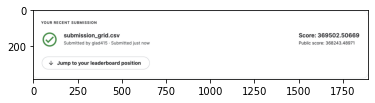

In [47]:
import os
import pickle
from PIL import Image

img_color = Image.open('/Users/keonkookkim/Desktop/aiffel_data/gridsearch_test.png')
img_color=np.array(img_color)

plt.imshow(img_color)
plt.show()

#### 랜덤 서치 값 앙상블

In [41]:
ensemble_random1 = LGBMRegressor(random_state=random_state,learning_rate = 0.13762086900938655, max_depth = 9, min_child_samples = 45, num_leaves= 78)
ensemble_random2 = XGBRegressor(random_state=random_state,eta= 0.40919355414712955, learning_rate= 0.11382177829621737, max_depth= 6, subsample=0)
ensemble_random3 = RandomForestRegressor(random_state=random_state,max_depth=9, min_samples_split= 8, n_estimators= 282)

In [42]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
 
ensemble_model = [('LGBM_grid',ensemble_random1),('XGB_grid',ensemble_random2),('RF_grid',ensemble_random3)] 
ensemble_random   = VotingRegressor(ensemble_model)
ensemble_random .fit(train, target)

VotingRegressor(estimators=[('LGBM_grid',
                             LGBMRegressor(learning_rate=0.13762086900938655,
                                           max_depth=9, min_child_samples=45,
                                           num_leaves=78, random_state=415)),
                            ('XGB_grid',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eta=0.4...
                                          max_bin=None, max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=6,
         

In [43]:
prediction_random= ensemble_random.predict(test)
prediction_random = np.expm1(prediction_random)
prediction_random

array([ 9152.07792851,  9480.73287163, 17150.6338462 , ...,
       12194.2838875 , 10499.36151256, 10820.87381943])

In [44]:
#sample_submission.csv 파일 가져오기 
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

# 모델 예측값 덮어씌우기
submission['price'] = prediction_random

In [45]:
result_random = pd.DataFrame({'id' : sub_id, 'price' : prediction_random})
result_random.head()
my_submission_path = join(data_dir, 'submission_random.csv')
result_random.to_csv(my_submission_path, index=False)

print(my_submission_path)

/Users/keonkookkim/Desktop/aiffel_data/EXP4/submission_random.csv


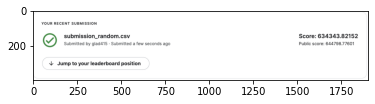

In [48]:
import os
import pickle
from PIL import Image

img_color = Image.open('/Users/keonkookkim/Desktop/aiffel_data/randomsearch_test.png')
img_color=np.array(img_color)

plt.imshow(img_color)
plt.show()

# 회고

- 결론적으로 보자면 캐글 11만 이하의 점수를 얻지 못하였다. 모델도 3가지를 사용하고 앙상블 기법도 찾아서 사용해 보았지만 모델 자체의 성능이 좋지 못해 앙상블 기법도 특별히 효과적이지 않았던 것 같다.  
- 상관관계가 적어 보이는 컬럼을 뺐을 때 오히려 캐글 점수가 증가하는 모습을 보여 어떤 방식으로 피쳐 엔지니어링과 EDA를 진행해야 할 지 갈피를 잡지 못했다. 
- 그리드 및 랜덤 서치를 진행 함에 있어서, 어떤 값이 모델에 어떤 영향을 미치는지 정확히 알지 못해 하이퍼 파라미터 설정을 하는 것에 있어 어려움을 느겼다.  
- 검색을 통해 추천 해주는 값과 디폴트값 주변의 값을 사용해 파라미터를 조정하였지만 원하는 수준의 캐글 점수를 얻지못한 것으로 보아 하이퍼 파라미터 설정에도 문제가 있을 수 있다고 생각이 들었다.

--------